### Model training

In [330]:
import bratsdataset
from torch.utils.data import DataLoader

#constructing datasets
train_path = '/Users/daniel/Documents/CSAI/Advanced Deep Learning/CODE/data/train/'
train_set = bratsdataset.BratsDataset(train_path)

val_path = '/Users/daniel/Documents/CSAI/Advanced Deep Learning/CODE/data/validation/'
val_set = bratsdataset.BratsDataset(val_path)

test_path = '/Users/daniel/Documents/CSAI/Advanced Deep Learning/CODE/data/test/'
test_set = bratsdataset.BratsDataset(test_path)

#data loaders
batch_size = 2 #8

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

#test
images, masks = next(iter(train_loader))
print("Image batch shape:", images.shape)
print("Mask batch shape:", masks.shape)

Image batch shape: torch.Size([2, 1, 240, 240, 160])
Mask batch shape: torch.Size([2, 1, 240, 240, 160])


In [2]:
import models
import loops
import utils
import torch
import torch.nn as nn
import torch.optim as optim

#setting up training
model = models.Unet3Dbrats()
device = torch.device("cpu")
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1
early_stopping = utils.EarlyStopping(patience=5, delta=0.001)

#constructing trainer
trainer = loops.Trainer(
    model=model, 
    device=device, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=num_epochs, 
    early_stopping=early_stopping, 
    train_loader=train_loader, 
    val_loader=val_loader,
    test_loader=test_loader, 
    save_path="Images/loss_test.png"
    )

In [ ]:
trainer.train()

In [5]:
trainer.test()

Test runtime 94.21402215957642
Mean dice coefficient on test set: 0.0222
Mean loss on test set: 0.6748


In [9]:
torch.save(model, "brats_model_test.pt")

### RISE

In [479]:
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import numpy as np
import bratsdataset
from scipy.ndimage import zoom
import random

device = torch.device('cpu')
model = torch.load("models/brats_model_test.pt", weights_only=False, map_location=device)

rise_path = '/Users/daniel/Documents/CSAI/Advanced Deep Learning/CODE/data/rise/'
rise_set = bratsdataset.BratsDataset(rise_path)
batch_size = 1
rise_loader = DataLoader(rise_set, batch_size=batch_size, shuffle=True)

images, masks = next(iter(rise_loader))
print("Image batch shape:", images.shape)
print("Mask batch shape:", masks.shape)

Image batch shape: torch.Size([1, 1, 240, 240, 160])
Mask batch shape: torch.Size([1, 1, 240, 240, 160])


In [218]:
#mask generation
mask_start = time.time()

n_generated = 3

complete_mask = np.empty((n_generated, 240, 240, 160), dtype=np.float32)

for n_masks in range(0, n_generated):
    #creating small random binary mask
    small_mask = np.random.randint(2, size=(24, 24, 16)).astype(np.float32)
    #bilinear interpolation
    upscaled = zoom(small_mask, zoom=20, order=1)
    #print(upscaled.shape)
    #print(np.unique(upscaled))

    z_drift = random.randint(0, 240)
    y_drift = random.randint(0, 240)
    x_drift = random.randint(0, 160)

    mask_with_drift = upscaled[z_drift:z_drift+240, y_drift:y_drift+240, x_drift:x_drift+160]
    #print(mask_with_drift.shape)

    #adding mask to mask array
    complete_mask[n_masks] = mask_with_drift.astype(np.float32)
    #print(complete_mask[n_masks])

mask_end = time.time()
print(f"Mask runtime {mask_end - mask_start}")
print()

mask_tensor = torch.from_numpy(complete_mask)
print(f"Mask tensor shape: {mask_tensor.shape}")

Mask runtime 7.698663949966431

Mask tensor shape: torch.Size([3, 240, 240, 160])


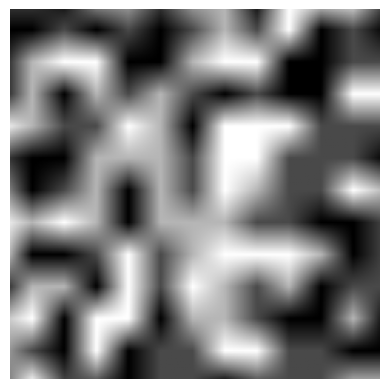

In [480]:
#mask printing
mask_slice = complete_mask[0, :, :, 89]

plt.figure()
plt.axis("off")
plt.imshow(np.flipud(mask_slice.T), cmap="gray")

In [481]:
#saliency map calculation
rise_start = time.time()

#global average pooling layer
glob_avg_pool = nn.AdaptiveAvgPool3d((1, 1, 1))

model.eval()
with torch.no_grad():

    for images, _ in rise_loader:

        heatmap = torch.zeros((240, 240, 160))

        images = images.to(device)
        rise_masks = mask_tensor.to(device)

        outputs = model(images)

        #global average pooling
        #glob_avg_tensor = glob_avg_pool(outputs)
        #global_average = glob_avg_tensor[0][0][0][0][0].item()
        #print(global_average)

        #loop to go over all masks
        for mask_number in range(rise_masks.size(0)):
            
            #output for each mask
            masked_images = images * rise_masks[mask_number]
            masked_output = model(masked_images)
            
            #global average pooling for each masked output
            masked_glob_avg = glob_avg_pool(masked_output)
            masked_global_average = masked_glob_avg[0][0][0][0][0].item()
            #print(f"Global average of mask: {masked_global_average}")

            #weighing each mask by the global average
            weighted = masked_global_average * rise_masks[mask_number]

            #adding the weighted mask to the heatmap
            heatmap = heatmap + weighted
            #print(heatmap.shape)


#normalization with sum of masks
norm_sum = rise_masks.sum(dim=0)
#print(norm_sum.shape)
heatmap = (heatmap.squeeze([0, 1])) / norm_sum

print(f"Final heatmap shape: {heatmap.shape}")

rise_end = time.time()
print(f"Rise runtime {rise_end - rise_start}")
print()

Final heatmap shape: torch.Size([240, 240, 160])
Rise runtime 19.683808088302612



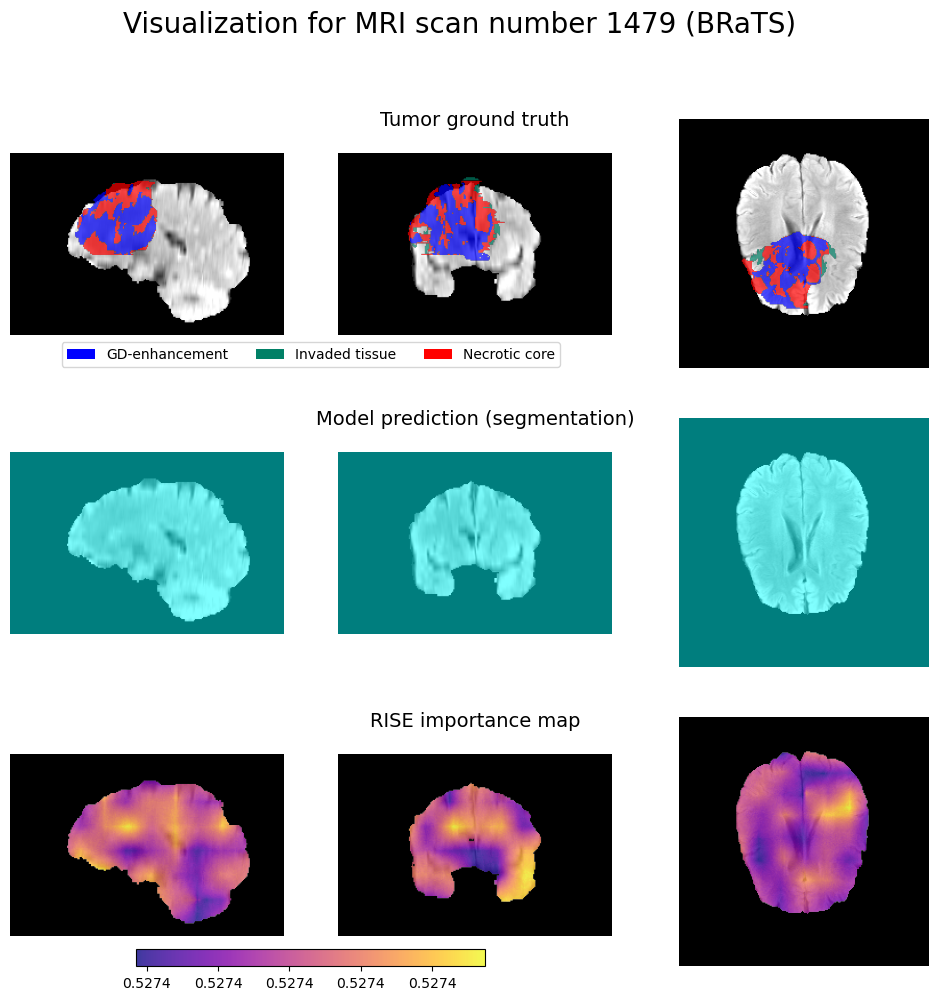

In [470]:
#plot RISE heatmap and segmentation

import nibabel as nib

mask_full = nib.load('/Users/daniel/Documents/CSAI/Advanced Deep Learning/CODE/data/rise/BraTS2021_01479/BraTS2021_01479_seg.nii.gz')
mask_full = np.asanyarray(mask_full.dataobj, dtype=np.float32)
mask_full = np.pad(mask_full, ((0, 0), (0, 0), (2, 3)), mode='constant', constant_values=0)

images, _ = next(iter(rise_loader))

outputs = model(images)
outputs = outputs.squeeze([0, 1])
outputs = outputs > 0.5
final_output = np.ma.masked_where(outputs == 0, outputs)

images = images.squeeze([0, 1])
#masks = masks.squeeze([0, 1])
#masks = np.ma.masked_where(masks == 0, masks)



binary_images = (images > 0).float()
heatmap_masked = heatmap * binary_images
final_heatmap = np.ma.masked_where(heatmap_masked == 0, heatmap_masked)

#masks per tumor area
mask_enhancing = (mask_full == 4).astype(np.float32)
mask_enhancing = np.ma.masked_where(mask_enhancing == 0, mask_enhancing)


mask_invaded = (mask_full == 2).astype(np.float32)
mask_invaded = np.ma.masked_where(mask_invaded == 0, mask_invaded)

mask_core = (mask_full == 1).astype(np.float32)
mask_core = np.ma.masked_where(mask_core == 0, mask_core)


#getting slices for visualization
image_slicez = images[103, :, :]
image_slicey = images[:, 100, :]
image_slicex = images[:, :, 89]
image_slices = [image_slicez, image_slicey, image_slicex]

output_slicez = final_output[103, :, :]
output_slicey = final_output[:, 100, :]
output_slicex = final_output[:, :, 89]
output_slices = [output_slicez, output_slicey, output_slicex]

#mask_slicez = masks[103, :, :]
#mask_slicey = masks[:, 100, :]
#mask_slicex = masks[:, :, 89]
#mask_slices = [mask_slicez, mask_slicey, mask_slicex]

mask_enhancing_slicez = mask_enhancing[103, :, :]
mask_enhancing_slicey = mask_enhancing[:, 100, :]
mask_enhancing_slicex = mask_enhancing[:, :, 89]
mask_enhancing_slices = [mask_enhancing_slicez, mask_enhancing_slicey, mask_enhancing_slicex]

mask_invaded_slicez = mask_invaded[103, :, :]
mask_invaded_slicey = mask_invaded[:, 100, :]
mask_invaded_slicex = mask_invaded[:, :, 89]
mask_invaded_slices = [mask_invaded_slicez, mask_invaded_slicey, mask_invaded_slicex]

mask_core_slicez = mask_core[103, :, :]
mask_core_slicey = mask_core[:, 100, :]
mask_core_slicex = mask_core[:, :, 89]
mask_core_slices = [mask_core_slicez, mask_core_slicey, mask_core_slicex]

heatmap_slicez = final_heatmap[103, :, :]
heatmap_slicey = final_heatmap[:, 100, :]
heatmap_slicex = final_heatmap[:, :, 89]
heatmap_slices = [heatmap_slicez, heatmap_slicey, heatmap_slicex]


#creating the figure
fig, axes = plt.subplots(3, 3, figsize=(12, 11))
fig.suptitle("Visualization for MRI scan number 1479 (BRaTS)", fontsize=20)
axes[0, 1].set_title("Tumor ground truth", fontsize=14, pad=20)
axes[1, 1].set_title("Model prediction (segmentation)", fontsize=14, pad=20)
axes[2, 1].set_title("RISE importance map", fontsize=14, pad=20)


from matplotlib.patches import Patch
import matplotlib.cm as cm

legend_elements = [
    Patch(facecolor=cm.winter(1), label='GD-enhancement'),
    Patch(facecolor=cm.summer(1), label='Invaded tissue'),
    Patch(facecolor=cm.autumn(1), label='Necrotic core')
]
axes[0, 0].legend(
    handles=legend_elements,
    loc='upper center',
    bbox_to_anchor=(1.1, 0),
    ncol=3,
    frameon=True
)



for i, s in enumerate(image_slices):
    axes[0, i].imshow(np.flipud(s.T), cmap='gray')
    axes[1, i].imshow(np.flipud(s.T), cmap='gray')
    axes[2, i].imshow(np.flipud(s.T), cmap='gray')

    axes[0, i].axis("off")
    axes[1, i].axis("off")
    axes[2, i].axis("off")

for i, s in enumerate(output_slices):
    axes[1, i].imshow(np.flipud(s.T), cmap='cool', alpha=0.5)

#for i, s in enumerate(mask_slices):
    #axes[0, i].imshow(np.flipud(s.T), cmap='spring', alpha=0.4)

for i, s in enumerate(mask_enhancing_slices):
    axes[0, i].imshow(np.flipud(s.T), cmap='winter', alpha=0.7)

for i, s in enumerate(mask_invaded_slices):
    axes[0, i].imshow(np.flipud(s.T), cmap='summer', alpha=0.7)

for i, s in enumerate(mask_core_slices):
    axes[0, i].imshow(np.flipud(s.T), cmap='autumn', alpha=0.7)

for i, s in enumerate(heatmap_slices):
    im = axes[2, i].imshow(np.flipud(s.T), cmap='plasma', alpha=0.8)


cbar = fig.colorbar(
    im,
    ax=[axes[2, 0], axes[2, 1]],
    orientation='horizontal',
    fraction=0.07,
    pad=0.05,
)
#cbar.set_label("Intensity")
#cbar.formatter.set_useOffset(False)
#cbar.update_ticks()

import matplotlib.ticker as ticker
#cbar.formatter = ticker.ScalarFormatter(useOffset=True)
cbar.formatter = ticker.FormatStrFormatter('%.4f')
cbar.locator = ticker.MaxNLocator(nbins=5)
#cbar.formatter.set_scientific(False)
cbar.update_ticks()
    
#plt.savefig("/images/rise_heatmap1.png")
#print('heatmap1')

[0, 2000000, 4000000, 6000000, 8000000]
[0.04045203700661659, 0.04045203700661659, 0.04045203700661659, 0.04045203700661659, 0.04045203700661659]
[0.04045203700661659, 0.04045203700661659, 0.04045203700661659, 0.04045203700661659, 0.04045203700661659]


/var/folders/6f/wxzyqfm94w75mzf9c72p5kd00000gn/T/ipykernel_15145/1752449253.py:132: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


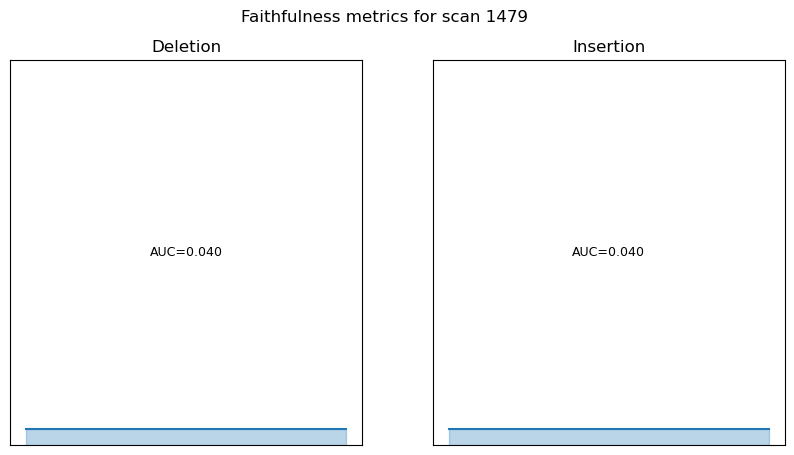

In [535]:
#function to remove top n values from a tensor
def remove_top_n(im, rise_im, n):

    rise_flattened = rise_im.view(-1)
    _, indices = torch.topk(rise_flattened, n)
    im_flattened = im.view(-1)
    im_flattened[indices] = 0
    rise_flattened[indices] = 0

#function to add top n values from a tensor
def add_top_n(im, original_im, rise_im, n):

    rise_flattened = rise_im.view(-1)
    _ , indices = torch.topk(rise_flattened, n)
    im_flattened = im.view(-1)
    original_im_flattened = original_im.view(-1)
    im_flattened[indices] = original_im_flattened[indices]
    rise_flattened[indices] = 0


#pixels to remove each run
n_pixels_remove = 2000000
im_size = 240 * 240 * 160

#insertion and deletion metrics
model.eval()
with torch.no_grad():


    for images, masks in rise_loader:

        
        images = images.to(device)
        im_deletion = images.clone()
        im_insertion = torch.zeros((1, 1, 240, 240, 160))
        im_insertion = im_insertion.to(device)
        heatmap_deletion = heatmap.clone()
        heatmap_insertion = heatmap.clone()

        n_pixels_list = []
        deletion_dice_list = []
        insertion_dice_list = []

        #deletion_global_average_list = []
        #insertion_global_average_list = []

        for n in range(0, im_size, n_pixels_remove): 


            deletion_output = model(im_deletion)
            deletion_dice = utils.dice_coeff(deletion_output, masks)

            #deletion_glob_avg = glob_avg_pool(deletion_output)
            #deletion_global_average = deletion_glob_avg[0][0][0][0][0].item()

            insertion_output = model(im_insertion)
            insertion_dice = utils.dice_coeff(insertion_output, masks)

            #insertion_glob_avg = glob_avg_pool(insertion_output)
            #insertion_global_average = insertion_glob_avg[0][0][0][0][0].item()

            remove_top_n(im_deletion, heatmap, n_pixels_remove)
            add_top_n(im_insertion, images, heatmap, n_pixels_remove)

            n_pixels_list.append(n)
            deletion_dice_list.append(deletion_dice)
            insertion_dice_list.append(insertion_dice)

            #deletion_global_average_list.append(deletion_global_average)
            #insertion_global_average_list.append(insertion_global_average)

        print(n_pixels_list)
        print(deletion_dice_list)
        print(insertion_dice_list)
        #print(deletion_global_average_list)
        #print(insertion_global_average_list)

        norm_pixel_list = []
        for pixels in n_pixels_list:
            norm_pixel_list.append(pixels / max(n_pixels_list))

        auc_deletion = np.trapz(deletion_dice_list, norm_pixel_list)
        auc_insertion = np.trapz(insertion_dice_list, norm_pixel_list)
        auc_deletion_text = "AUC=" + auc_deletion.__format__('.3f')
        auc_insertion_text = "AUC=" + auc_insertion.__format__('.3f')
        
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        fig.suptitle("Faithfulness metrics for scan 1479")
        axes[0].set_title("Deletion")
        axes[1].set_title("Insertion")


        axes[0].plot(n_pixels_list, deletion_dice_list, color='C0')
        axes[0].fill_between(n_pixels_list, deletion_dice_list, alpha=0.3, color="C0")
        axes[0].set_ylim(0, 1)

        axes[1].plot(n_pixels_list, insertion_dice_list, color='C0')
        axes[1].fill_between(n_pixels_list, insertion_dice_list, alpha=0.3, color="C0")
        axes[1].set_ylim(0, 1)


        axes[0].set_xticks([])
        axes[0].set_yticks([])
        #axes[0].spines["top"].set_visible(False)
        #axes[0].spines["right"].set_visible(False)

        axes[1].set_xticks([])
        axes[1].set_yticks([])
        #axes[1].spines["top"].set_visible(False)
        #axes[1].spines["right"].set_visible(False)


        axes[0].text(
        0.5, 0.5,
        auc_deletion_text,
        transform=axes[0].transAxes,
        ha="center",
        va="center",
        fontsize=9
        )
    
        axes[1].text(
        0.5, 0.5,
        auc_insertion_text,
        transform=axes[1].transAxes,
        ha="center",
        va="center",
        fontsize=9
        )

        fig.show()

